## Feature extraction
In this notebook an approach to preprocessing microphone data is explored. The idea is to group individual readings from a 8-channel audio recording into sequences longer sequences (for example of length 20). This will effectively create a list of matrices from the original data. Then, each matrix can be used to extract individual channel data and compute generalized cross-correlation (GCC-PHAT) between each pair of microphones.

#### Imports

In [88]:
import numpy as np
import pandas as pd
import os
from itertools import combinations
from statistics import mode
import matplotlib.pyplot as plt
import math
from scipy.signal import correlate

#### GCC-PHAT computation
Here the function for computing GCC is defined:

In [107]:
def gcc_phat(x_1, x_2, FS=16000):
    """
    Function that will compute the GCC-PHAT
    cross-correlation of two separate audio channels
    
    Returns:
        A 1-D GCC vector
    """
    
    max_len = math.ceil(0.09 / 340 * FS)
    
    n = len(x_1) + len(x_2) - 1
    
    # Fourier transforms of the two signals
    X_1 = np.fft.rfft(x_1, n=n)
    X_2 = np.fft.rfft(x_2, n=n)
    
    # GCC-PHAT = [X_1(f)X_2*(f)] / |X_1(f)X_2*(f)|
    # See http://www.xavieranguera.com/phdthesis/node92.html for reference
    CC = X_1 * np.conj(X_2)
    
    cc = np.fft.irfft(CC, n=n)
    
    max_len = math.ceil(0.09 / 340 * FS)
    
    # Trim the cc vector to only include a 
    # small number of samples around the origin
    cc = np.concatenate((cc[-max_len:], cc[:max_len+1]))
    
    # Return the cross correlation
    return cc




Let's test the above function and plot an example cross-correlation between an arbitrary signal and its noisy version:

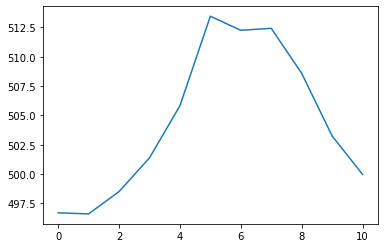

11


496.69992208971235

In [108]:
sig = np.repeat([0., 1., 1., 0., 1., 0., 0., 1.], 128)
sig_noise = sig + np.random.randn(len(sig))

gcc = gcc_phat(sig, sig_noise)
plt.plot(gcc)
plt.show()

print(len(gcc))
gcc[0]

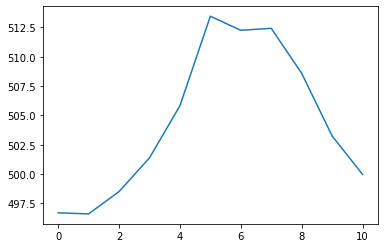

11

In [110]:
cc = correlate(sig, sig_noise)
mid = len(cc) // 2
cc = cc[mid-5:mid+6]
plt.plot(cc)
plt.show()


cc[0]
len(cc)

#### Creating observations
In the following code cell one can find a function that accepts a pandas dataframe containing rows of consecutive readings from a microphone array and transforms it into a list of GCC matrices.

In [5]:
def create_observations(dataframe, samples=1, step=1, resolution=20):
    """
    Create list of observations from the pandas dataframe.
    Each observation will be a GCC matrix, where each row is a vector
    of GCC between a given pair of microphones.
    
    Returns: 
        a tuple of observations and their corresponding labels
    """
    
    # Lists of observations and labels that will be populated
    X = []
    y = []
    
    # Loop through the dataframe and take subframes
    for i in range(0, len(dataframe) - samples + 1, step):
        sub_df = dataframe.iloc[i : i + samples]
        
        # Extract the label as the most common label
        # from the subframe
        label = mode(sub_df['angle'])
        rounded_label = round(label / resolution) * resolution
        y.append(rounded_label)
        
        # Extract the observation from subframe by discarding the label column
        observation = np.array(sub_df.iloc[:, :-1])
        
        mic_pairs = combinations(dataframe.columns[:-1], r=2)
        
        # Initialize a transformed observation, that will be populated with GCC vectors
        # of the observation
        transformed_observation = []
        
        # Compute GCC for every pair of microphones
        for mic_1, mic_2 in mic_pairs:
            x_1 = observation[:, int(mic_1[-1]) - 1]
            x_2 = observation[:, int(mic_2[-1]) - 1]
            
            gcc = gcc_phat(x_1, x_2)
            
            # Add the GCC vector to the GCC matrix
            transformed_observation.append(gcc)
            
        # Add the GCC matrix to the list of observations
        X.append(transformed_observation)
        
    return X, y

#### Testing the function to create observations

In [10]:
path = os.path.join('..', 'training_data', 'angle_10_dist_50_CantinaBand3.csv')
df = pd.read_csv(path, dtype=np.int16)

X, y = create_observations(df, samples=20, step=5, resolution=20)

print('X shape: ' + str(np.shape(X)))
print('y shape: ' + str(np.shape(y)))

X shape: (13301, 15, 42)
y shape: (13301,)
